In [117]:
import numpy as np
from scipy import linalg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [118]:
class statevector(np.ndarray): #extends the np.ndarray class to add functionalities like normalize, evolve under hamiltonian and also obtain density matrix
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def get_norm(self):
        normVal = self.H()@self
        try:
            return normVal[0][0].real
        except:
            return normVal.real
    
    def normalize(self):
        if self.get_norm() != 0:
            self[:] = self/(self.get_norm()**0.5)
        return self
    
    def evolve(self, Hamiltonian, time, method='exact', dt=0):
        if method not in ['exact', 'trotter']:
            raise AttributeError(f"The specified method '{method}' does not exist.")
        
        if method == 'exact':
            evolvedstate = linalg.expm(-1j*Hamiltonian*time)@self
        else:
            size, __ = Hamiltonian.shape
            trotter_term = (operator(np.identity(size)) - 1j*Hamiltonian*dt)
            N = int(time/dt)
            evolvedstate = self
            for __ in range(N):
                evolvedstate = trotter_term@evolvedstate
            evolvedstate.view(statevector).normalize()
        
        self[:] = evolvedstate
        return self
    
    def get_rho(self):
        state = np.copy(self).view(statevector)
        state.normalize()
        rho = state@state.H()
        return rho.view(operator)


class operator(np.ndarray): #extends the np.ndarray class to add functionalities like expectation value of the operator for a given statevector
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def expectation_value(self, state:statevector):
        state.normalize()
        exp_val =  state.H()@self@state
        try:
            return exp_val[0][0].real
        except:
            return exp_val.real

def natural_range(*args): #used to prevent confusions in coversion from natural index used in Hamiltonian and other Operators to python index
    '''
    natural_range(start, end) yields (i_p, i_n) where i_p is the programming index starting from start-1 to end-1 and i_n is the natural index starting from start to end. 
    'start' will default to 1 if natural_range is called with single arg.
    '''
    try:
        start = args[-2] - 1
    except:
        start = 0
    
    end = args[-1]
    
    for i in range(start, end):
        yield (i, i+1)


In [119]:
# basic defs
sx = operator([[0, 1],[1, 0]])
sy = operator([[0, -1j],[1j, 0]])
sz = operator([[1, 0],[0, -1]])
sp = (sx + 1j*sy)/2
sm = (sx - 1j*sy)/2
id_2 = operator(np.eye(2))

def Rx(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sx/2))
def Ry(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sy/2))
def Rz(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sz/2))


In [120]:
class VQE():
        def __init__(
                self, 
                init_state: statevector,
                init_theta: tuple,
                hamiltonian: operator,
                learning_rate: float = 1e-3
        ):
                super().__init__()
                self.state = init_state
                self.hamiltonian = hamiltonian
                self.theta_x, self.theta_y, self.theta_z = init_theta
                self.learning_rate = learning_rate

        def rotation_operator(
                self
        ) -> operator:
                theta_x_list = self.theta_x
                theta_y_list = self.theta_y
                theta_z_list = self.theta_z

                rotation_operator_list = [Rx(theta_x)@Ry(theta_y)@Rz(theta_z) for (theta_x, theta_y, theta_z) in zip(theta_x_list, theta_y_list, theta_z_list)]

                rotation_operator = rotation_operator_list[0]
                for op in rotation_operator_list[1:]:
                        rotation_operator = np.kron(rotation_operator, op)

                return operator(rotation_operator)
        
        def rotated_state(
                        self
        ):
                rotation_operator = self.rotation_operator()
                return statevector(rotation_operator@self.state)
        
        def get_energy(
                        self
        )-> float:
                hamiltonian = self.hamiltonian
                rotation_operator = self.rotation_operator()
                rotated_hamiltonian = rotation_operator.H() @ hamiltonian @ rotation_operator
                energy = rotated_hamiltonian.expectation_value(self.state)
                return energy
        
        def get_gradients(
                        self
        ) -> tuple[list[float], list[float], list[float]]:
                theta_x = self.theta_x
                theta_y = self.theta_y
                theta_z = self.theta_z
                hamiltonian = self.hamiltonian
                state = self.state

                rotation_operator = self.rotation_operator()

                N = len(theta_x)

                d_theta_x = []
                d_theta_y = []
                d_theta_z = []

                d_theta_x_list = [[(1j/2)*sx@Rx(theta_x[i])@Ry(theta_y[i])@Rz(theta_z[i]) if i==j else Rx(theta_x[i])@Ry(theta_y[i])@Rz(theta_z[i]) for i in range(N)] for j in range(N)]
                d_theta_y_list = [[(1j/2)*Rx(theta_x[i])@sy@Ry(theta_y[i])@Rz(theta_z[i]) if i==j else Rx(theta_x[i])@Ry(theta_y[i])@Rz(theta_z[i]) for i in range(N)] for j in range(N)]
                d_theta_z_list = [[(1j/2)*Rx(theta_x[i])@Ry(theta_y[i])@sz@Rz(theta_z[i]) if i==j else Rx(theta_x[i])@Ry(theta_y[i])@Rz(theta_z[i]) for i in range(N)] for j in range(N)]

                for i in range(N):
                        temp = d_theta_x_list[i][0]
                        for op in d_theta_x_list[i][1:]:
                                temp = np.kron(temp, op)
                        d_theta_x.append(operator(temp))

                        temp = d_theta_y_list[i][0]
                        for op in d_theta_y_list[i][1:]:
                                temp = np.kron(temp, op)
                        d_theta_y.append(operator(temp))

                        temp = d_theta_z_list[i][0]
                        for op in d_theta_z_list[i][1:]:
                                temp = np.kron(temp, op)
                        d_theta_z.append(operator(temp))

                gradient_x = []
                gradient_y = []
                gradient_z = []
                for i in range(N):
                        d_x = (rotation_operator.H() @ hamiltonian @ d_theta_x[i] + d_theta_x[i].H() @ hamiltonian @ rotation_operator).expectation_value(state)
                        gradient_x.append(d_x)
                        d_y = (rotation_operator.H() @ hamiltonian @ d_theta_y[i] + d_theta_y[i].H() @ hamiltonian @ rotation_operator).expectation_value(state)
                        gradient_y.append(d_y)
                        d_z = (rotation_operator.H() @ hamiltonian @ d_theta_z[i] + d_theta_z[i].H() @ hamiltonian @ rotation_operator).expectation_value(state)
                        gradient_z.append(d_z)

                return gradient_x, gradient_y, gradient_z
        
        def apply_gradients(
        self
        )->tuple[float]:
                learning_rate = self.learning_rate
                theta_x = self.theta_x
                theta_y = self.theta_y
                theta_z = self.theta_z

                init_energy = self.get_energy()

                gradient_x, gradient_y, gradient_z = self.get_gradients()

                max_grad = max(max(map(abs, gradient_x)), max(map(abs, gradient_y)), max(map(abs, gradient_z)))

                self.theta_x[:] = [theta - learning_rate*gradient for (theta, gradient) in zip(theta_x, gradient_x)]
                self.theta_y[:] = [theta - learning_rate*gradient for (theta, gradient) in zip(theta_y, gradient_y)]
                self.theta_z[:] = [theta - learning_rate*gradient for (theta, gradient) in zip(theta_z, gradient_z)]  

                fin_energy = self.get_energy()

                perc_change = abs(100*(init_energy - fin_energy)/init_energy)

                return fin_energy, perc_change, max_grad

In [121]:
def get_pauli(
        N:int,
        ) -> tuple[list[operator]]:
    sigma_p = []
    sigma_m = []
    sigma_z = []

    sp_listform = [[sp if k==l else id_2 for k in range(N)] for l in range(N)]
    sm_listform = [[sm if k==l else id_2 for k in range(N)] for l in range(N)]
    sz_listform = [[sz if k==l else id_2 for k in range(N)] for l in range(N)]

    for i in range(N):
        temp = sp_listform[i][0]
        for pauli in sp_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_p.append(temp)

        temp = sm_listform[i][0]
        for pauli in sm_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_m.append(temp)

        temp = sz_listform[i][0]
        for pauli in sz_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_z.append(temp)

    id_N = operator(np.eye(2**N))

    return sigma_p, sigma_m, sigma_z, id_N

In [122]:
def get_hamiltonian(
        N:int, 
        coeffs: tuple[float]
        )->operator:
    '''
    takes N: numer of lattice sites and coeffs: (M, J, W) and returns the Hamiltonian for the system
    '''
    (sigma_p, sigma_m, sigma_z, id_N) = get_pauli(N)
    (M, J, W) = coeffs

    # the natural_range method returns the tuple (python index, natural index), which I have denoted by adding _p and _n to the indices

    # H_Z

    hamiltonian_z1 = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        hamiltonian_z1 += (-1)**n_n*sigma_z[n_p]
    hamiltonian_z1 *= (M/(2*W))

    hamiltonian_z2 = operator(np.zeros_like(id_N))
    
    for (n_p, n_n) in natural_range(1, N-1):
        coeff = 1 - (-1)**n_n
        if coeff!=0:
            term = operator(np.zeros_like(id_N))
            for (l_p, l_n) in natural_range(1, n_n):
                term += sigma_z[l_p]
            hamiltonian_z2 += coeff*term

    hamiltonian_z2 *= (-J)/(4*W)

    hamiltonian_z = hamiltonian_z1 + hamiltonian_z2

    # H_{\pm}

    hamiltonian_pm = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-1):
        term = sigma_p[n_p]@sigma_m[n_p + 1]
        hamiltonian_pm += term + term.H()
    
    # H_{ZZ}
    hamiltonian_zz = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-2):
        for (l_p, l_n) in natural_range(n_n+1, N-1):
            hamiltonian_zz += (N - l_n)*sigma_z[n_p]@sigma_z[l_p]
    hamiltonian_zz *=  (J/(2*W))

    hamiltonian = hamiltonian_z + hamiltonian_pm + hamiltonian_zz

    return hamiltonian

In [123]:
def get_particle_density(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    particle_density = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        particle_density += ((-1)**n_n)*sigma_z[n_p] + id_N

    particle_density /= (2*N)

    return particle_density

the order parameter is given by the operator

$$
\mathcal{O} = \frac{1}{2N(N-1)} \sum_{i=1}^N \sum_{j=i+1}^N (1 + (-1)^i\sigma_i^z)(1 + (-1)^j\sigma_j^z)
$$

In [124]:
def get_order_parameter(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    order_parameter = operator(np.zeros_like(id_N))

    for (i_p, i_n) in natural_range(1, N):
        for (j_p, j_n) in natural_range(i_n+1, N):
            order_parameter += ( ((-1)**i_n)*sigma_z[i_p] + id_N ) @ ( ((-1)**j_n)*sigma_z[j_p] + id_N ) 

    order_parameter /= (2*N*(N-1))

    return order_parameter

In [125]:
def get_rand_state(N:int, seed:int=19203):
    sys_size = 2**N
    np.random.seed(seed)
    state = statevector([ np.random.rand(1) + np.random.rand(1)*1j for i in range(sys_size) ])
    state.normalize()

    return state

In [126]:
def get_rand_thetas(N:int, seed:int=12731):
    np.random.seed(seed)
    thetas = np.random.uniform(low=0, high=4*np.pi, size=3*N)
    return thetas[0:N],  thetas[N:2*N], thetas[2*N:3*N]

In [127]:
def get_init_state(N:int, m:float):
    up = statevector([[1], [0]])
    down = statevector([[0], [1]])
    psi = up if m>0 else down
    for (n_p, n_n) in natural_range(2, N):
        if n_n%2 != 0:
            psi = np.kron(psi, up) if m>0 else np.kron(psi, down)
        else:
            psi = np.kron(psi, down) if m>0 else np.kron(psi, up)

    return psi




In [128]:
num_sites = [4,6]
learning_rate = 1e-1
masses = [-5, -2, -1, -0.6, -0.2, 0.2, 0.6, 1, 2, 5]
epochs = 5000
energies = []
states = []


In [129]:

for N in num_sites:
    energies.append([])
    states.append([])
    for m in masses:
        print(f'Number of sites: {N}, Mass: {m}')
        coeffs = (m, 1, 1)
        init_state = get_init_state(N, m)
        hamiltonian = get_hamiltonian(N, coeffs)
        init_theta = get_rand_thetas(N, seed = 18748539)
        system = VQE(init_state = init_state, init_theta=init_theta, hamiltonian=hamiltonian, learning_rate=learning_rate)

        for epoch in range(epochs):
            energy, energy_diff, max_grad = system.apply_gradients()
            if epoch%100 == 0:
                print(f'Epoch: {epoch}, Energy: {energy}, Percentage Energy Change: {energy_diff}, Max Grad: {max_grad}')
            if max_grad < 1e-5:
                break

        energies[-1].append(energy)
        states[-1].append(system.rotated_state())
        clear_output()

In [130]:
# import pickle

# energy_pickle_file = open('dumps/energies', 'ab')
# pickle.dump(energies, energy_pickle_file)
# energy_pickle_file.close()

# states_pickle_file = open('dumps/states', 'ab')
# pickle.dump(states, states_pickle_file)
# states_pickle_file.close()


In [131]:
# import pickle

# energies_file = open('dumps/energies', 'rb')
# energies = pickle.load(energies_file)
# energies_file.close()

# states_file = open('dumps/states', 'rb')
# states = pickle.load(states_file)
# states_file.close()

In [143]:
def exact_diagonalisation(hamiltonian):
    e,v = np.linalg.eigh(hamiltonian)
    min_e = np.min(e)
    id = np.where(e == min_e)[0][0]
    return e[id], v[:,id]

In [144]:
states_e = []
energies_e = []
masses_e = np.linspace(-5, 5, 50)

for N in num_sites:
    states_e.append([])
    energies_e.append([])
    for m in masses_e:
        coeffs = (m, 1, 1)
        hamiltonian = get_hamiltonian(N, coeffs)
        energy, state = exact_diagonalisation(hamiltonian)
        states_e[-1].append(state)
        energies_e[-1].append(energy)


In [145]:
particle_densities_e = []
for i in range(len(num_sites)):
    particle_density_op = get_particle_density(num_sites[i])
    ground_states_e = states_e[i]
    particle_densities_e.append([particle_density_op.expectation_value(statevector(state)) for state in ground_states_e])

In [146]:
particle_densities = []
for i in range(len(num_sites)):
    particle_density_op = get_particle_density(num_sites[i])
    ground_states = states[i]
    particle_densities.append([particle_density_op.expectation_value(statevector(state)) for state in ground_states])

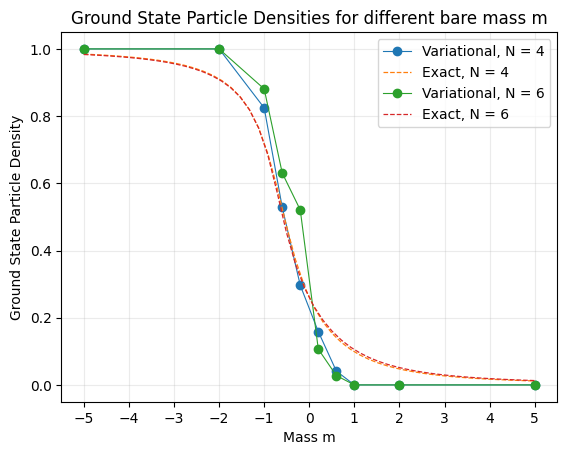

In [157]:

fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, particle_densities[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, particle_densities_e[i], '--', linewidth=0.9, label=f'Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel("Mass m")
ax.set_ylabel("Ground State Particle Density")
ax.set_title("Ground State Particle Densities for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)

In [148]:
order_parameters_e = []
for i in range(len(num_sites)):
    order_parameter_op = get_order_parameter(num_sites[i])
    ground_states = states_e[i]
    order_parameters_e.append([order_parameter_op.expectation_value(statevector(state)) for state in ground_states])

In [150]:
order_parameters = []
for i in range(len(num_sites)):
    order_parameter_op = get_order_parameter(num_sites[i])
    ground_states = states[i]
    order_parameters.append([order_parameter_op.expectation_value(statevector(state)) for state in ground_states])

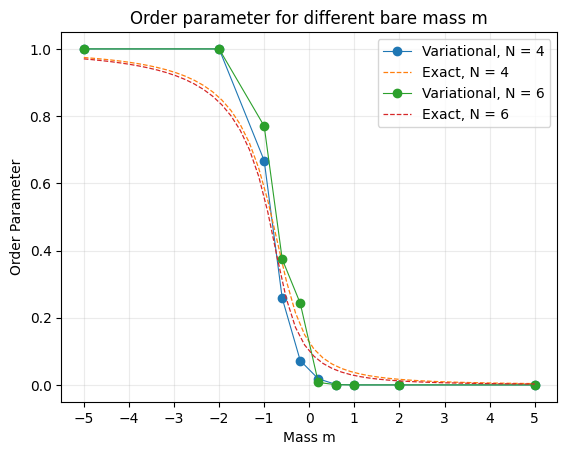

In [156]:

fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, order_parameters[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, order_parameters_e[i], '--', linewidth=0.9, markersize=12, label=f'Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel("Mass m")
ax.set_ylabel("Order Parameter")
ax.set_title("Order parameter for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)

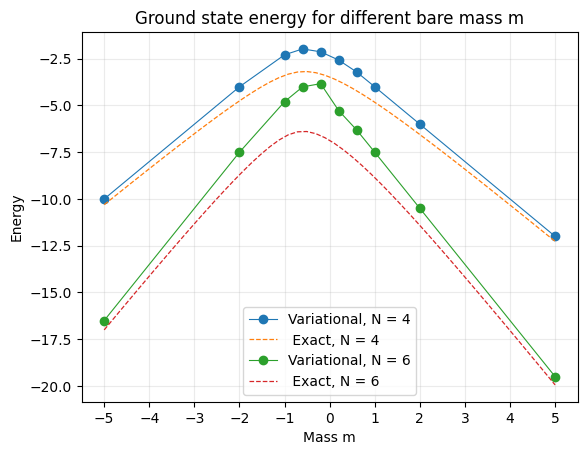

In [155]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, energies[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, energies_e[i], '--', linewidth=0.9, markersize=12, label=f' Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel("Mass m")
ax.set_ylabel("Energy")
ax.set_title("Ground state energy for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)